In [1]:
from mm import *

In [2]:
best_params_mfi = {
                'kandle_size': 12,
                'mfi_range': 1830,
                'mfi_value': 16}

best_params_devmfi = {'index_coef': 0.013659422371663978,
                    'price_coef': -0.01793041179016943,
                    'shift': 14}

In [3]:
df = pd.read_csv('../data/price-volume-minute_btc-usd.csv',header=None)
df.columns = ['price','volume','time']
df = df.astype({'time':'datetime64[ms]'}).set_index('time').sort_index()

In [4]:
def calc_mfi(df,price_col='price',vol_col='volume',kandle_size=12,mfi_range=1800):
    dd = df.copy()
    dd[price_col] = dd[price_col].rolling(kandle_size,1).mean()
    pmf = dd.where(dd[price_col].diff() > 0).rolling(mfi_range,1).agg({price_col:'sum',vol_col:'sum'}) 
    pmf = pmf[price_col] * pmf[vol_col]
    nmf = dd.where(dd[price_col].diff() < 0).rolling(mfi_range,1).agg({price_col:'sum',vol_col:'sum'}) 
    nmf = nmf[price_col] * nmf[vol_col]
    return (100 - 100/(1 + pmf/nmf))

In [5]:
def check_profit_probability(data,w8_period=1440,probability = True,profit = 0.00):
    if probability:
        return np.mean( (data[:w8_period] * (1-profit)) / data[0] )
    return any(data[0] < (data[:w8_period] * (1-profit)))

In [6]:
def check_profit(data,w8_period=1440,probability = True,profit = 0.05):
    if probability:
        return np.mean(data[0] < (data[:w8_period] * (1-profit)) )
    return any(data[0] < (data[:w8_period] * (1-profit)))

In [7]:
def validate_strategy(data,idx,sample_size=1000,**kwargs):
    return list(map(lambda i: check_profit_probability(data.loc[i:].values,**kwargs),idx))

In [8]:
def trend_sampler(df,thr = .9,resampler = '24H'):
    if thr < 1:
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) < thr).dropna().index
    else :
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) > thr).dropna().index


In [9]:
# fig,ax = plt.subplots(2,1)
# idx = np.random.randint(df.shape[0]-1000)
# idx_df = df.iloc[idx-1000:idx+1000].index
# df.loc[idx_df,'price'].plot(ax=ax[0],title='Price')
# calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).plot(ax=ax[1],title='MFI',color='b')
# buy_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x < 20).dropna().index
# sell_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x > 80).dropna().index
# [ax[0].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
# [ax[1].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
# plt.tight_layout()
# (df.loc[sell_idx]['price'].resample('min').mean().fillna(method='bfill') - df.loc[buy_idx]['price'].resample('min').mean()).dropna().clip(-1,1).round().value_counts(normalize=True)

In [10]:
def devirgence(data,shift=10):
    f1 = data
    f2 = data.shift(shift)
    return f1 / f2 - 1

In [11]:
def div_check(data,price_col='price',vol_col='volume',price_coef= 0,index_coef = 0,shift=30):
    price_dv = devirgence(data[price_col],shift=shift)
    mfi_dv = devirgence(calc_mfi(data,vol_col=vol_col,price_col=price_col),shift=shift)
    return (price_dv < price_coef) & (mfi_dv >index_coef)

In [36]:
dfs = df['price'].loc['2021']

In [37]:
mfi_idx = calc_mfi(df.loc[dfs.index]).where(lambda x: x<25).dropna().index
dvmfi_idx = div_check(df.loc[dfs.index],**best_params_devmfi).where(lambda x: x==True).dropna().index
dvmfi_idx2 = div_check(df.loc[dfs.index],price_coef=-0.018,index_coef=0.019,shift=235).where(lambda x: x==True).dropna().index
rng_idx = np.random.choice(dfs.index,len(mfi_idx))
print(f'MFI point counts {len(mfi_idx)} \n')
print(f'DVMFI_5% point counts {len(dvmfi_idx)} \n')
print(f'DVMFI_3% point counts {len(dvmfi_idx2)} \n')

MFI point counts 1040 

DVMFI_5% point counts 31 

DVMFI_3% point counts 3774 



In [14]:
# rng = Parallel(n_jobs=6, verbose=10)(delayed(validate_strategy)(data=dfs,idx=rng_idx,probability=True,sample_size=500) for _ in range(1000))
# mfi = Parallel(n_jobs=6, verbose=10)(delayed(validate_strategy)(data=dfs,idx=dvmfi_idx2,probability=True,sample_size=500) for _ in range(1000))
# dvmfi = Parallel(n_jobs=6, verbose=10)(delayed(validate_strategy)(data=dfs,idx=dvmfi_idx,probability=True,sample_size=500) for _ in range(1000))

In [15]:
# plt.hist(np.array(mfi).mean(axis=1),bins=50);
# plt.hist(np.array(dvmfi).mean(axis=1),bins=50);
# plt.hist(np.array(rng).mean(axis=1),bins=50);
# plt.legend(['mfi','div','rng'])

In [16]:
rng = validate_strategy(data=dfs,idx=rng_idx,probability=True,sample_size=500)
mfi = validate_strategy(data=dfs,idx=dvmfi_idx2,probability=True,sample_size=500)
dvmfi = validate_strategy(data=dfs,idx=dvmfi_idx,probability=True,sample_size=500)

In [17]:
pd.DataFrame([rng,mfi,dvmfi],index=['rng','mfi','divergence']).T.agg(['mean','std'])

,rng,mfi,divergence
mean,1.002127,1.007044,1.004483
std,0.021463,0.034066,0.065490


array([[<AxesSubplot:title={'center':'rng'}>,
        <AxesSubplot:title={'center':'mfi'}>],
       [<AxesSubplot:title={'center':'divergence'}>, <AxesSubplot:>]],
      dtype=object)

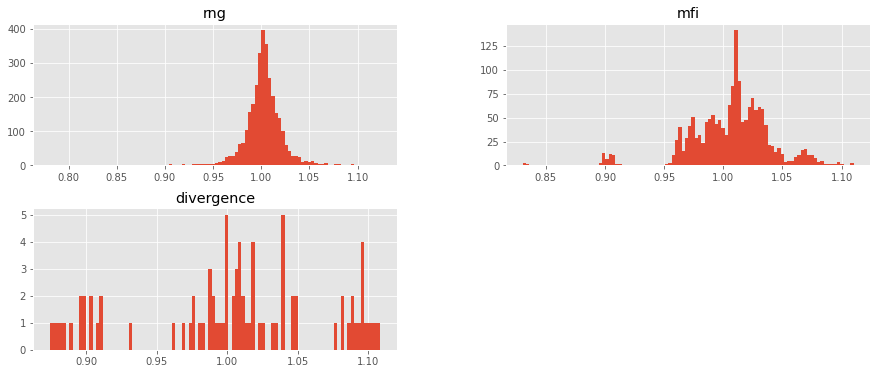

In [18]:
pd.DataFrame([rng,mfi,dvmfi],index=['rng','mfi','divergence']).T.hist(bins=100)

Text(0.5, 0.98, '2021-02-22 15:17:00')

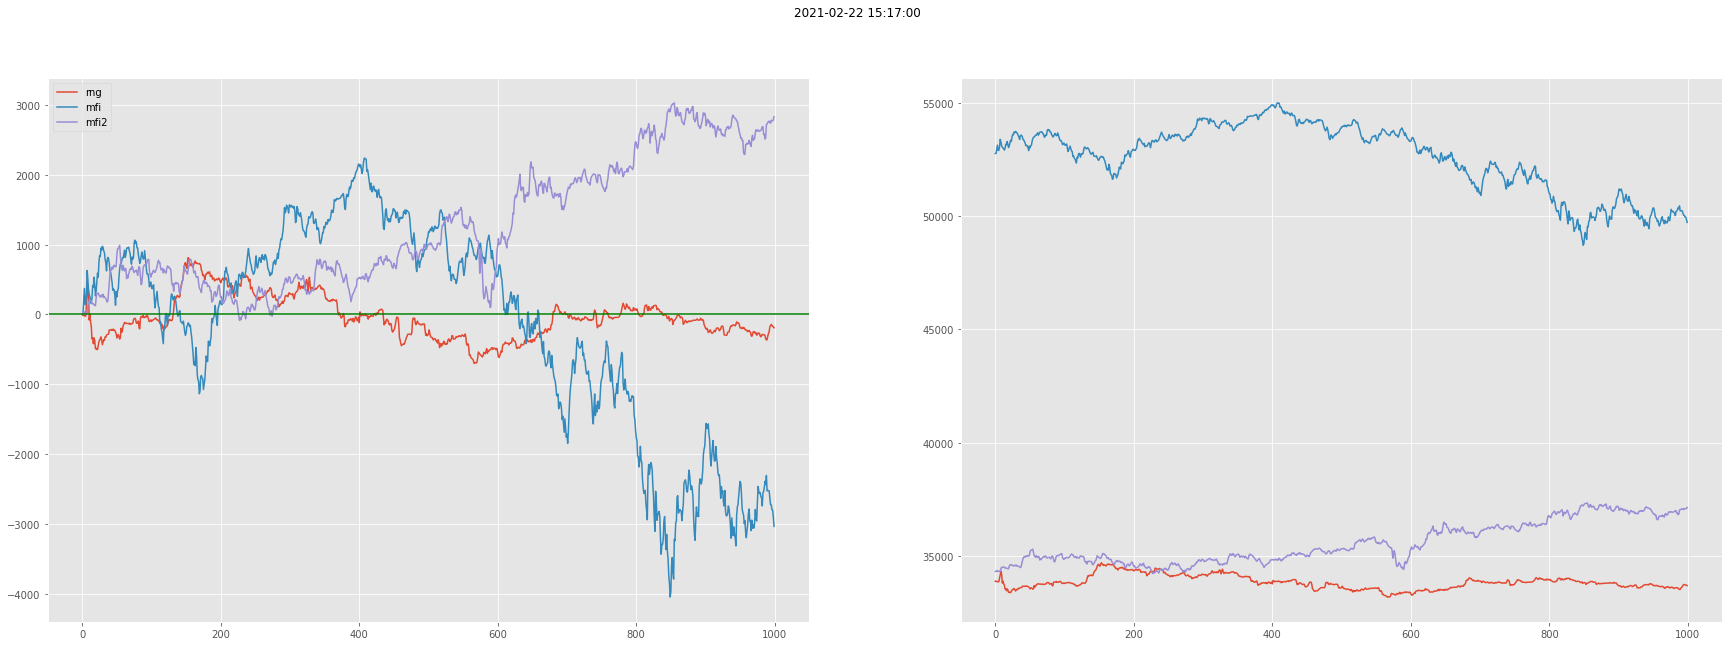

In [95]:
fig,ax=plt.subplots(1,2,figsize=(30,10))
num_idx = np.random.randint(len(dvmfi_idx))
dfs.loc[rng_idx[num_idx]:].iloc[:1000].sub(dfs.loc[rng_idx[num_idx]]).reset_index(drop=True).plot(ax=ax[0])
dfs.loc[dvmfi_idx[num_idx]:].iloc[:1000].sub(dfs.loc[dvmfi_idx[num_idx]]).reset_index(drop=True).plot(ax=ax[0])
dfs.loc[dvmfi_idx2[num_idx]:].iloc[:1000].sub(dfs.loc[dvmfi_idx2[num_idx]]).reset_index(drop=True).plot(ax=ax[0])

dfs.loc[rng_idx[num_idx]:].iloc[:1000].reset_index(drop=True).plot(ax=ax[1])
dfs.loc[dvmfi_idx[num_idx]:].iloc[:1000].reset_index(drop=True).plot(ax=ax[1])
dfs.loc[dvmfi_idx2[num_idx]:].iloc[:1000].reset_index(drop=True).plot(ax=ax[1])
ax[0].legend(['rng','mfi','mfi2'])
ax[0].axhline(0,color='g')
plt.suptitle(dvmfi_idx[num_idx])

In [20]:
# dfs.plot()
# [ plt.axvline(i,color='g',linestyle='--') for i in np.random.choice(mfi_idx,200)];

In [21]:
# idx = np.datetime_as_string(np.random.choice(trend_sampler(df['price'].loc['2021'],thr=.9)),'D')
# df.loc[str(idx),'price'].plot()

In [22]:
import optuna

In [25]:
def rng_check(n=1000):
    rng_more = []
    has_more = []
    has_more2 = []
    for _ in tqdm(range(n)):
        idx = np.random.randint(df.shape[0]-4000)
        idx_df = df.iloc[idx:idx+4000].index
        
        buy_idx = div_check(df.loc[idx_df],price_coef=-0.019,index_coef=0.016,shift=15).where(lambda x: x==True).dropna().index
        buy_idx2 = div_check(df.loc[idx_df],price_coef=-0.018,index_coef=0.0188,shift=230).where(lambda x: x==True).dropna().index
        try:
            rng_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=np.random.choice(idx_df,100),sample_size=100,probability=True)))
            has_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=buy_idx,sample_size=100,probability=True)))
            has_more2.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=buy_idx2,sample_size=100,probability=True)))
        except:
            pass
    return rng_more,has_more,has_more2

In [26]:
rng = rng_check()

100%|██████████| 1000/1000 [00:26<00:00, 37.87it/s]


array([[<AxesSubplot:title={'center':'rng'}>,
        <AxesSubplot:title={'center':'mfi_5%'}>],
       [<AxesSubplot:title={'center':'mfi_any'}>, <AxesSubplot:>]],
      dtype=object)

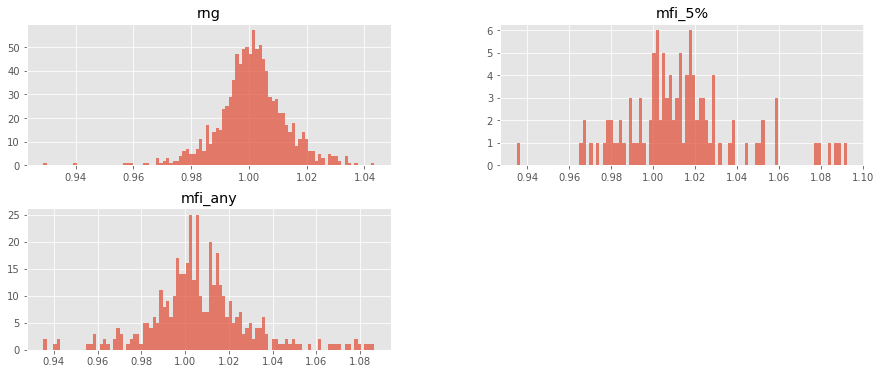

In [82]:
pd.DataFrame(rng,index=['rng','mfi_5%','mfi_any']).T.hist(bins=100,alpha=0.7)

In [33]:
pd.DataFrame(rng,index=['rng','mfi_5%','mfi_any']).T.agg(['mean','std'])

,rng,mfi_5%,mfi_any
mean,1.001055,1.013145,1.007009
std,0.011724,0.027501,0.022600


In [201]:
def hyp_obj(trial):
    
    kandle = trial.suggest_int('kandle_size',5,30)
    ma_range = trial.suggest_int('mfi_range',30,2000,30)
    mfi_value = trial.suggest_int('mfi_value',5,30)
    has_more = [0,1]
    rng_more = [0,1]
    for i in range(50):
        idx = np.random.randint(df.shape[0]-4000)
        idx_df = df.iloc[idx:idx+4000].index
        buy_idx = calc_mfi(df.loc[idx_df],kandle_size=kandle,mfi_range=ma_range).where(lambda x: x < mfi_value).dropna().index[:100]
        try:
            has_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=buy_idx,probability=True,profit=0.00)))
            rng_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=np.random.choice(idx_df,len(buy_idx)),probability=True,profit=0.00)))
        except:
            pass

    return np.mean(np.array(has_more) - np.array(rng_more))

In [202]:

study = optuna.create_study(direction='maximize')
study.optimize(hyp_obj, n_trials=100)


[I 2022-04-08 16:10:46,633] A new study created in memory with name: no-name-87709f45-9749-499e-87f3-f674fdd24df7
[W 2022-04-08 16:10:48,227] Trial 0 failed, because the objective function returned nan.
[W 2022-04-08 16:10:48,800] Trial 1 failed, because the objective function returned nan.
[I 2022-04-08 16:10:56,150] Trial 2 finished with value: 0.005009853904244352 and parameters: {'kandle_size': 27, 'mfi_range': 300, 'mfi_value': 28}. Best is trial 2 with value: 0.005009853904244352.
[I 2022-04-08 16:11:01,502] Trial 3 finished with value: 0.0008928108121635648 and parameters: {'kandle_size': 11, 'mfi_range': 330, 'mfi_value': 28}. Best is trial 2 with value: 0.005009853904244352.
[W 2022-04-08 16:11:02,229] Trial 4 failed, because the objective function returned nan.
[W 2022-04-08 16:11:05,250] Trial 5 failed, because the objective function returned nan.
[I 2022-04-08 16:11:11,813] Trial 6 finished with value: 0.001981945519705892 and parameters: {'kandle_size': 29, 'mfi_range': 60

In [203]:
study.trials_dataframe().loc[:,['value','params_kandle_size','params_mfi_range','params_mfi_value']].sort_values(by='value',ascending=False).iloc[:5].mean().to_dict()

{'value': 0.004815937906813629,
 'params_kandle_size': 22.2,
 'params_mfi_range': 270.0,
 'params_mfi_value': 21.0}

In [204]:
study.trials_dataframe().sort_values(by='value',ascending=False).iloc[:5]

,number,value,datetime_start,datetime_complete,duration,params_kandle_size,params_mfi_range,params_mfi_value,state
9,9,0.006682,2022-04-08 16:11:16.889114,2022-04-08 16:11:23.572070,0 days 00:00:06.682956,27,480,28,COMPLETE
2,2,0.005010,2022-04-08 16:10:48.801617,2022-04-08 16:10:56.150548,0 days 00:00:07.348931,27,300,28,COMPLETE
35,35,0.004460,2022-04-08 16:12:21.579820,2022-04-08 16:12:24.749850,0 days 00:00:03.170030,8,120,17,COMPLETE
37,37,0.004168,2022-04-08 16:12:25.448445,2022-04-08 16:12:28.134782,0 days 00:00:02.686337,21,210,12,COMPLETE
18,18,0.003760,2022-04-08 16:11:45.952415,2022-04-08 16:11:52.043207,0 days 00:00:06.090792,28,240,20,COMPLETE


In [41]:
def hyp_obj_div(trial):
    
    price_coef = trial.suggest_float('price_coef',-0.02,0)
    index_coef = trial.suggest_float('index_coef',0,.02)
    shift = trial.suggest_int('shift',5,500,5)
    has_more = [0,1]
    rng_more = [0,1]
    for i in range(100):
        idx = np.random.randint(df.shape[0]-4000)
        idx_df = df.iloc[:idx+4000].index
        buy_idx = div_check(df.loc[idx_df],price_coef=price_coef,index_coef=index_coef,shift=shift).where(lambda x: x==True).dropna().index[:100]
        try:
            has_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=buy_idx,probability=True,profit=0)))
            rng_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=np.random.choice(idx_df,len(buy_idx)),probability=True,profit=0)))
        except:
            
            pass

    return np.mean(np.array(has_more) - np.array(rng_more))

In [42]:

study_div = optuna.create_study(direction='maximize')
study_div.optimize(hyp_obj_div, n_trials=100)


[I 2022-04-08 17:21:56,519] A new study created in memory with name: no-name-c2837952-75a0-491b-b8e3-f479e12c8a1d
[I 2022-04-08 17:22:44,345] Trial 0 finished with value: -0.011458005789363008 and parameters: {'price_coef': -0.0037812699960620526, 'index_coef': 0.009693131737389216, 'shift': 460}. Best is trial 0 with value: -0.011458005789363008.
[I 2022-04-08 17:23:32,414] Trial 1 finished with value: -0.018113851269865006 and parameters: {'price_coef': -0.0006026522880139794, 'index_coef': 0.01327408994982343, 'shift': 465}. Best is trial 0 with value: -0.011458005789363008.
[I 2022-04-08 17:24:12,645] Trial 2 finished with value: 0.01854069379797223 and parameters: {'price_coef': -0.007673544735935286, 'index_coef': 0.011461354858529567, 'shift': 285}. Best is trial 2 with value: 0.01854069379797223.
[I 2022-04-08 17:24:51,904] Trial 3 finished with value: -0.015416087672486917 and parameters: {'price_coef': -0.006450369165484946, 'index_coef': 0.006915451224643694, 'shift': 480}. 

In [23]:
study_div.trials_dataframe().sort_values(by='value',ascending=False).loc[:,['value','params_index_coef','params_price_coef','params_shift']].iloc[:5].mean().iloc[1:].to_dict()

{'params_index_coef': 0.01836385874856744,
 'params_price_coef': -0.01191564144977865,
 'params_shift': 250.0}

In [24]:
study_div.trials_dataframe().sort_values(by='value',ascending=False).loc[:,['value','params_index_coef','params_price_coef','params_shift']].iloc[:10]

,value,params_index_coef,params_price_coef,params_shift
94,0.054832,0.018589,-0.007584,230
42,0.052120,0.016402,-0.018836,315
86,0.051781,0.019992,-0.011137,235
99,0.051321,0.018449,-0.010881,235
88,0.050479,0.018388,-0.011141,235
89,0.050394,0.018550,-0.011125,235
51,0.048610,0.012352,-0.016353,310
43,0.048053,0.012830,-0.016466,310
63,0.047818,0.018558,-0.014545,245
92,0.047224,0.019098,-0.007992,235
